In [1]:
import pandas as pd
import re
from urllib.parse import urlparse

In [2]:
import psycopg2
from psycopg2 import sql

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import psycopg2
import pandas as pd

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    dbname='DMGroupAssignment',
    user='postgres',
    password='Okpanachi',
    host='localhost',
    port='5432'
)

# Create a cursor object
cursor = conn.cursor()

# Query to calculate the average worldwide_box_office and select Movie_ID, production_budget, and worldwide_box_office
query = """
WITH avg_box_office AS (
    -- Calculate the average worldwide_box_office for valid rows
    SELECT AVG(mv.worldwide_box_office) AS avg_worldwide_box_office
    FROM MovieTable AS mv
    INNER JOIN ProductionBudget AS pb ON mv.Movie_ID = pb.Movie_ID
    WHERE pb.production_budget IS NOT NULL
    AND mv.worldwide_box_office IS NOT NULL
    AND mv.worldwide_box_office <> 'NaN'  -- Filter out 'NaN' values
)
SELECT 
    pb.Movie_ID,
    pb.production_budget,
    -- Fill missing worldwide_box_office values with the calculated average
    COALESCE(mv.worldwide_box_office, ROUND((SELECT avg_worldwide_box_office FROM avg_box_office), 2)) AS worldwide_box_office
FROM ProductionBudget AS pb
INNER JOIN MovieTable AS mv ON pb.Movie_ID = mv.Movie_ID
WHERE pb.production_budget IS NOT NULL
AND pb.production_budget <> 'NaN'
AND mv.worldwide_box_office IS NOT NULL  -- Ensure worldwide_box_office has a value
AND mv.worldwide_box_office <> 'NaN'
ORDER BY pb.production_budget ASC;
"""

# Execute the query
cursor.execute(query)

# Fetch all the rows from the result
rows = cursor.fetchall()

# Fetch the column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a DataFrame from the result
df_pbTable = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
conn.close()

# Display the DataFrame
print(df_pbTable)


      movie_id production_budget worldwide_box_office
0        17302           7000.00            841926.00
1        20077           7000.00             71644.00
2        21926          10000.00            683509.00
3        20064          15000.00            195254.00
4        24079          20000.00               849.00
...        ...               ...                  ...
4153     30280      365000000.00        1395316979.00
4154     32195      379000000.00        1045713802.00
4155     15551      379000000.00        1045713802.00
4156     30281      400000000.00        2797800564.00
4157     26691      400000000.00        2797800564.00

[4158 rows x 3 columns]


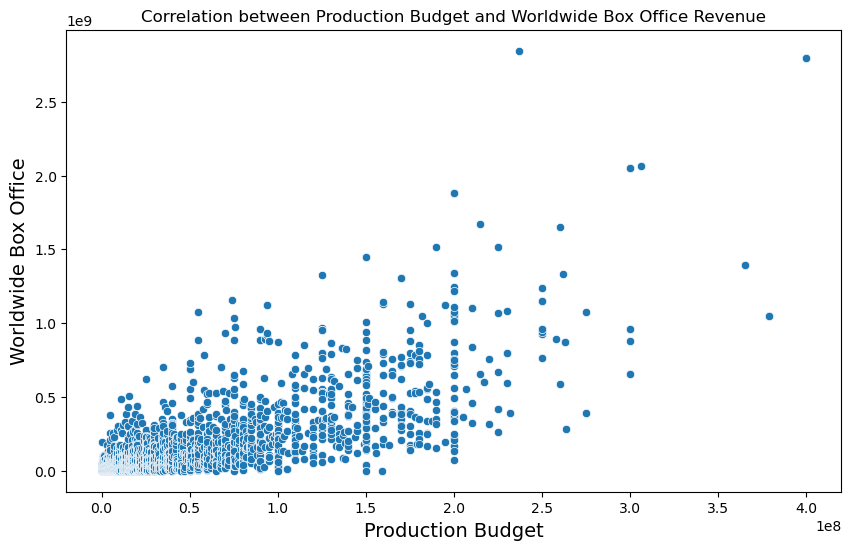

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot using seaborn for a scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='production_budget', y='worldwide_box_office', data=df_pbTable)

# Add labels and title
plt.title('Correlation between Production Budget and Worldwide Box Office Revenue', fontsize=12)
plt.xlabel('Production Budget', fontsize=14)
plt.ylabel('Worldwide Box Office', fontsize=14)

# Display the plot
plt.show()


The analysis shows a positive correlation between production budget and worldwide box office revenue. As the production budget increases, the worldwide box office revenue tends to rise as well, supporting the hypothesis that higher production budgets are associated with greater box office success.

                  genre avg_production_budget avg_worldwide_box_office  \
0       Multiple Genres           27330000.00              25134267.00   
1                Action           89618264.82             285566258.62   
2     Thriller/Suspense           34969292.68              92008517.28   
3             Adventure           87475911.72             285654894.75   
4               Musical           47066666.67             147592358.47   
5               Western           41664285.71              62626722.20   
6          Black Comedy           20129710.14              53778565.45   
7                 Drama           22141970.26              55268057.60   
8           Documentary            5646556.96              23602918.68   
9                Comedy           27106502.43              70513260.93   
10      Romantic Comedy           28563097.83              81786295.23   
11               Horror           19356043.99              78833438.11   
12  Concert/Performance            908

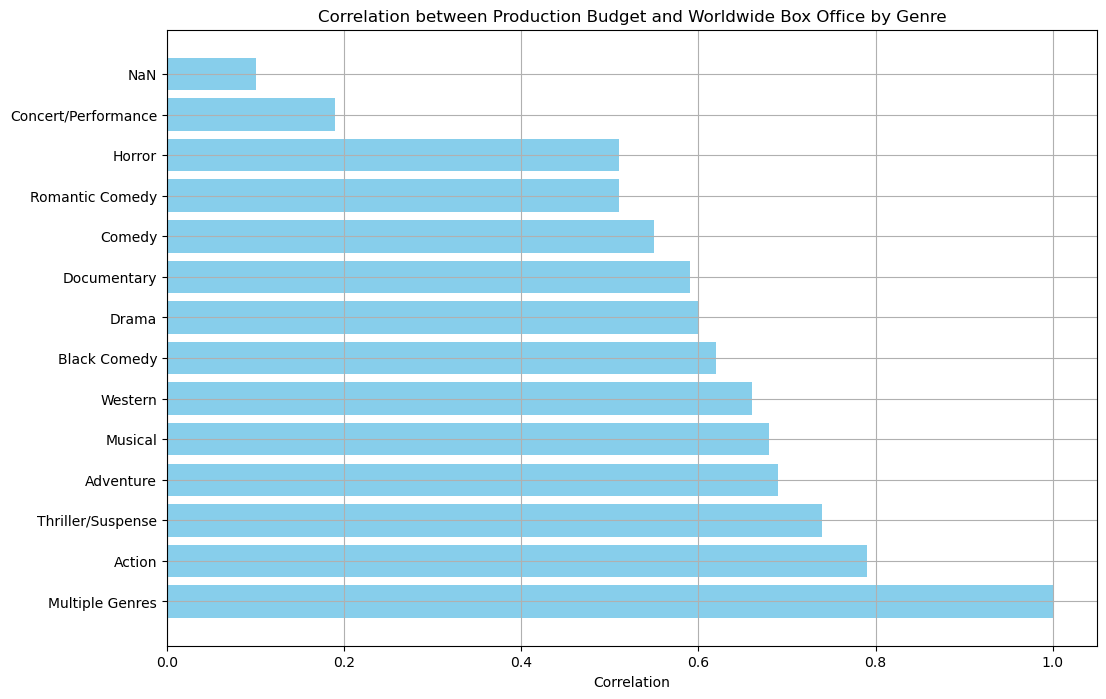

In [6]:
# Connect to the PostgreSQL database
conn = psycopg2.connect(
    dbname='DMGroupAssignment',
    user='postgres',
    password='Okpanachi',
    host='localhost',
    port='5432'
)

# Create a cursor object
cursor = conn.cursor()

# SQL query to calculate correlations for each genre
query = """
WITH avg_box_office AS (
    SELECT
        mv.Movie_ID,
        pb.production_budget,
        mv.worldwide_box_office,
        gt.genre
    FROM ProductionBudget AS pb
    INNER JOIN MovieTable AS mv ON pb.Movie_ID = mv.Movie_ID
    INNER JOIN genre AS gt ON mv.Movie_ID = gt.Movie_ID
    WHERE pb.production_budget IS NOT NULL
    AND pb.production_budget <> 'NaN'
    AND mv.worldwide_box_office IS NOT NULL
    AND mv.worldwide_box_office <> 'NaN'
)
SELECT
    genre,
    ROUND(AVG(production_budget), 2) AS avg_production_budget,
    ROUND(AVG(worldwide_box_office), 2) AS avg_worldwide_box_office,
    ROUND(CAST(CORR(production_budget, worldwide_box_office) AS NUMERIC), 2) AS correlation
FROM avg_box_office
GROUP BY genre
ORDER BY correlation DESC;
"""

# Execute the query
cursor.execute(query)

# Fetch all rows from the result
rows = cursor.fetchall()

# Fetch the column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a DataFrame from the result
df_genre_correlation = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
conn.close()

# Format the DataFrame to ensure 2 decimal places for all numerical values
df_genre_correlation = df_genre_correlation.round(2)

# Display the DataFrame
print(df_genre_correlation)

# Plotting the correlations for each genre
plt.figure(figsize=(12, 8))
plt.barh(df_genre_correlation['genre'], df_genre_correlation['correlation'], color='skyblue')
plt.xlabel('Correlation')
plt.title('Correlation between Production Budget and Worldwide Box Office by Genre')
plt.grid(True)
plt.show()
